In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(openxlsx)
    library(survival)
    library(survminer)
    library(coxphf)
    library(forestplot)
    library(stepp)
})

In [2]:
# Load the dataset
data <- read.xlsx("data/Assignment Data Nov 2025.xlsx")

In [3]:
# remove the rows with missing values
df <- na.omit(data)

## Question 1: Is there a difference in PFS between the treatment groups? Please elaborate.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Ignoring unknown labels:
• colour : "Strata"


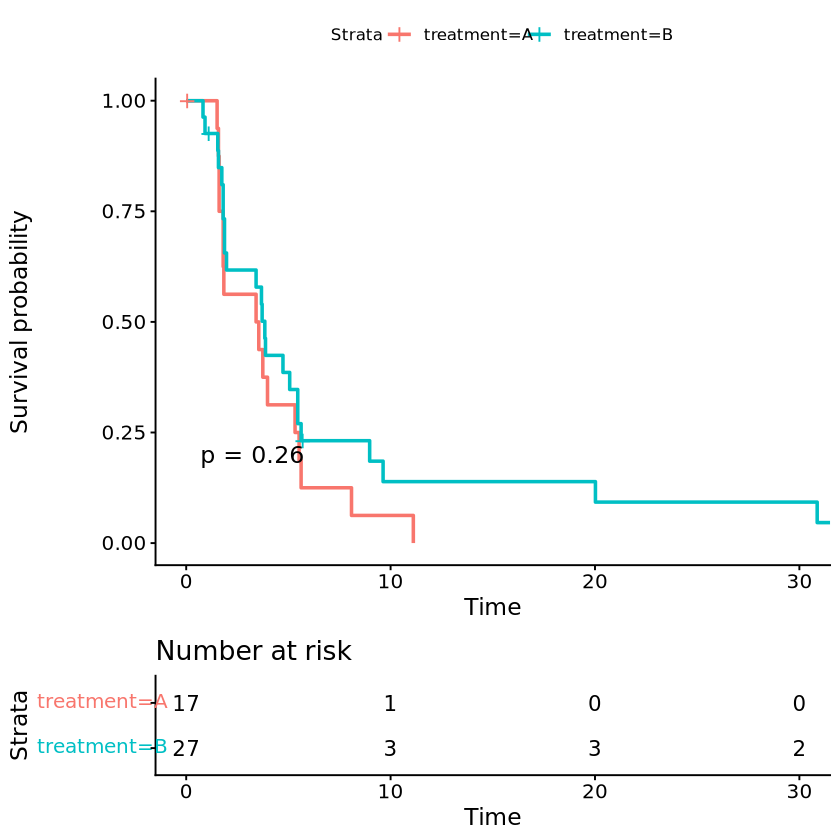

In [4]:
# draw KM plot to study the difference in PFS between the treatment groups

# Create a survival object
surv_object <- Surv(time = df$time.pfs, event = df$event.pfs)

# Fit the survival curves
fit <- survfit(surv_object ~ df$treatment)

# Plot the survival curves
ggsurvplot(fit, data = df, pval = TRUE, risk.table = TRUE)

In [5]:
# Run Cox regression to estimate the hazard ratio (HR) between treatment groups
# Check whether Cox regression analyses have met the assumption of proportional hazards
cox_model <- coxph(surv_object ~ df$treatment)
ph_test <- cox.zph(cox_model)
ph_pvalue <- ph_test$table[1, "p"]
if (ph_pvalue < 0.05) {
    cat("Warning: Proportional hazards assumption may be violated for treatment variable\n")
}
ph_pvalue

[1] 0.5302582

In [6]:
# Check the Cox model summary
beta <- coef(cox_model)[1]
se <- sqrt(vcov(cox_model)[1, 1])
cox_treatment_result <- data.frame(
    HR = exp(beta),
    HR_lower = exp(beta - 1.96 * se),
    HR_upper = exp(beta + 1.96 * se),
    p_value = summary(cox_model)$coefficients[1, "Pr(>|z|)"],
    stringsAsFactors = FALSE
)
cox_treatment_result

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
df$treatmentB,0.6925678,0.3622747,1.323996,0.2665201


In [7]:
# Considering the sample size is 44, use coxphf to fit Cox Regression with Firth's Penalized Likelihood
penalized_fit <- coxphf::coxphf(Surv(time.pfs, event.pfs) ~ treatment, df)
beta_pena <- penalized_fit$coefficients[1]
se_pena <- sqrt(diag(penalized_fit$var))[1]
cox_treatment_pena <- data.frame(
    HR = exp(beta_pena),
    HR_lower = exp(beta_pena - 1.96 * se_pena),
    HR_upper = exp(beta_pena + 1.96 * se_pena),
    p_value = penalized_fit$prob[1],
    stringsAsFactors = FALSE
)
cox_treatment_pena

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
treatmentB,0.6900251,0.3610582,1.31872,0.2610211


## Answer to Question 1 based on the analysis above
In the two-group (A = Chemotherapy + placebo, B = Chemotherapy + atezolizumab (immunotherapy / PD-L1 inhibitor)) comparison of progression-free survival (PFS), the Cox model estimated Hazard Ration (HR) is 0.69 (95% CI 0.36–1.32; P-value = 0.27). The Cox regression analysis has met the assumption of proportional hazards. Considering the sample size (n=44), the small-sample bias was taken care by fitting a Firth-penalized Cox model, and it gave similar results. And the Kaplan-Meier log-rank test was P-value = 0.26.

The consistent results indicate that there is no statistically significant difference in PFS between the two treatment groups. Though the estimated hazard ratio as 0.69 implies a lower risk of progression with atezolizumab, but the wide 95% confidence interval includes 1, ranging from benefit (HR=0.36) to increase in risk (HR=1.32), which indicates uncertainty.

## Question 2: Please assess whether any of the numerical gene expression scores are associated with progression-free survival in this dataset.

In [8]:
# List the column names of the 8 gene expressions
cols_to_exclude <- c("treatment", "time.pfs", "event.pfs", "id")
cols_exp <- setdiff(colnames(df), cols_to_exclude)
cols_exp

[1] "TIS"             "APM"             "Cytotoxic.Cells" "Cell.Adhesion"  
[5] "Macrophages"     "HRD"             "PD.L2"           "Claudin.Low"

In [9]:
# Check whether Cox regression analyses have met the assumption of proportional hazards
ph_assumptions <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    model <- coxph(cox_formula, data = df)
    ph_test <- cox.zph(model)
    ph_pvalue <- ph_test$table[1, "p"]
    if (ph_pvalue < 0.05) {
        cat("Warning: Proportional hazards assumption may be violated for gene", gene, "\n")
    }
    ph_assumptions[[i]] <- data.frame(
        gene = gene,
        p_value = ph_pvalue,
        stringsAsFactors = FALSE
    )
}
ph_assumptions <- bind_rows(ph_assumptions)
ph_assumptions

gene,p_value
<chr>,<dbl>
TIS,0.9690752
APM,0.6267775
Cytotoxic.Cells,0.9436848
Cell.Adhesion,0.3037935
Macrophages,0.9034903
HRD,0.7543653
PD.L2,0.5904097
Claudin.Low,0.3680182


In [10]:
# Run Cox regression on each gene expression with PFS, stratifying the treatment
cox_gene_results <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    model <- coxph(cox_formula, data = df)
    beta <- coef(model)[1]
    se <- sqrt(vcov(model)[1, 1])
    cox_gene_results[[i]] <- data.frame(
        HR = exp(beta),
        HR_lower = exp(beta - 1.96 * se),
        HR_upper = exp(beta + 1.96 * se),
        p_value = summary(model)$coefficients[1, "Pr(>|z|)"],
        stringsAsFactors = FALSE
    )
}
cox_gene_results <- bind_rows(cox_gene_results)
cox_gene_results

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
TIS,0.7628480,0.5670273,1.0262946,0.07369308
APM,0.7400094,0.5816535,0.9414778,0.01425094
Cytotoxic.Cells,0.6986305,0.4960194,0.9840029,0.04014207
Cell.Adhesion,1.0751782,0.9310604,1.2416038,0.32355132
Macrophages,0.6662358,0.4045021,1.0973245,0.11066955
HRD,1.0050754,0.6577921,1.5357078,0.98132629
PD.L2,0.6466131,0.4341052,0.9631500,0.03197793
Claudin.Low,0.8173325,0.6223500,1.0734030,0.14689231


In [11]:
# Still run Cox regression on each gene expression with PFS, stratifying the treatment, but considering the small sample issue
cox_gene_small_sample <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]
    cox_formula <- as.formula(sprintf("Surv(time.pfs, event.pfs) ~ %s + strata(treatment)", gene))
    penalized_fit <- coxphf::coxphf(cox_formula, data = df)
    beta_pena <- penalized_fit$coefficients[1]
    se_pena <- sqrt(diag(penalized_fit$var))[1]
    cox_gene_small_sample[[i]] <- data.frame(
        HR = exp(beta_pena),
        HR_lower = exp(beta_pena - 1.96 * se_pena),
        HR_upper = exp(beta_pena + 1.96 * se_pena),
        p_value = penalized_fit$prob[1],
        stringsAsFactors = FALSE
    )
}
cox_gene_small_sample <- bind_rows(cox_gene_small_sample)
cox_gene_small_sample

,HR,HR_lower,HR_upper,p_value
,<dbl>,<dbl>,<dbl>,<dbl>
TIS,0.7665290,0.5701434,1.0305596,0.07918711
APM,0.7520218,0.5956806,0.9493959,0.01646902
Cytotoxic.Cells,0.6988466,0.4976061,0.9814722,0.04124580
Cell.Adhesion,1.0697955,0.9309081,1.2294042,0.30978378
Macrophages,0.6551237,0.4007076,1.0710730,0.08984742
HRD,0.9794952,0.6464268,1.4841755,0.92183398
PD.L2,0.6286213,0.4235690,0.9329407,0.02452061
Claudin.Low,0.8174394,0.6271234,1.0655116,0.11523445


In [12]:
q_BH <- p.adjust(cox_gene_results$p_value, method = "BH")
q_BH

[1] 0.1473862 0.1070455 0.1070455 0.3697729 0.1770713 0.9813263 0.1070455
[8] 0.1958564

## Answer to Question 2 based on the analysis above
A Cox model was fit for each gene stratified by treatment (assumption of proportional hazards was met, and small-sample bias made no big difference and therefore ignored).

Three gene expression scores are significantly (P-value < 0.05) associated with PFS:
APM: HR = 0.75 (95% CI 0.58-0.94, P-value = 0.01)
Cytotoxic.Cells: HR = 0.70 (95% CI 0.50-0.98, P-value = 0.04)
PD.L2: HR = 0.65 (95% CI 0.43-0.96, P-value = 0.03).

And their hazard ratios and the 95% confidence intervals (HR,95%CI < 1) indicate that their higher expressions associate with better PFS.

Be noted: since multiple tests were run and the multiple P-values were adjusted by Benjamini-Hochberg, but then none of them passed the significance threshold 0.05.

## Question 3 a): Are any of the scores potential predictive biomarkers for the experimental treatment? 


 TIS median: 6.698 
Group sizes: 22 22 

 APM median: 12.256 
Group sizes: 22 22 

 Cytotoxic.Cells median: 4.054 
Group sizes: 22 22 

 Cell.Adhesion median: 8.327 
Group sizes: 22 22 

 Macrophages median: 6.599 
Group sizes: 22 22 

 HRD median: 5.33 
Group sizes: 22 22 

 PD.L2 median: 4.47 
Group sizes: 22 22 

 Claudin.Low median: 0.587 
Group sizes: 22 22 


,gene,hr_high,hr_high_lower,hr_high_upper,high_pvalue,hr_low,hr_low_lower,hr_low_upper,low_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
treatmentB...1,TIS,0.6723760,0.2376642,1.9022197,0.45440565,1.0434967,0.4223039,2.578440,0.92649947
treatmentB...2,APM,0.6919174,0.2474098,1.9350475,0.48275114,0.7849128,0.3027815,2.034761,0.61826654
treatmentB...3,Cytotoxic.Cells,0.5930615,0.2216705,1.5866883,0.29809130,1.4419755,0.5774651,3.600725,0.43309189
treatmentB...4,Cell.Adhesion,1.5650404,0.5899939,4.1514858,0.36817947,0.3688455,0.1319942,1.030704,0.05713405
treatmentB...5,Macrophages,0.4107398,0.1558328,1.0826168,0.07195040,1.3493513,0.5265632,3.457798,0.53258338
treatmentB...6,HRD,0.5755754,0.2241522,1.4779556,0.25095137,0.6685407,0.2518553,1.774617,0.41885991
treatmentB...7,PD.L2,0.5391296,0.2104444,1.3811759,0.19804280,1.0683051,0.4179819,2.730443,0.89023744
treatmentB...8,Claudin.Low,0.3280494,0.1183411,0.9093744,0.03214688,1.7697791,0.7067351,4.431813,0.22289849


gene,interaction_pvalue,high_group_pvalue,low_group_pvalue
<chr>,<dbl>,<dbl>,<dbl>
TIS,0.571131654,0.45440565,0.92649947
APM,0.725314287,0.48275114,0.61826654
Cytotoxic.Cells,0.210064141,0.29809130,0.43309189
Cell.Adhesion,0.039144281,0.36817947,0.05713405
Macrophages,0.061758082,0.07195040,0.53258338
HRD,0.851462920,0.25095137,0.41885991
PD.L2,0.363157271,0.19804280,0.89023744
Claudin.Low,0.009921877,0.03214688,0.22289849


Ignoring unknown labels:
• colour : "TIS Expression"
Ignoring unknown labels:
• colour : "APM Expression"


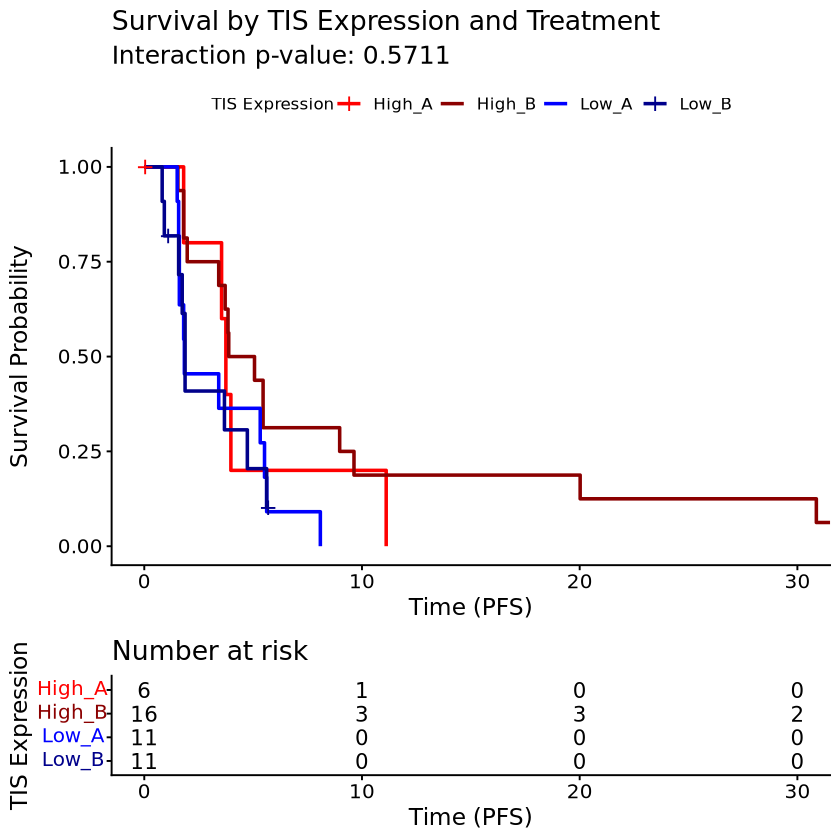

Ignoring unknown labels:
• colour : "Cytotoxic.Cells Expression"


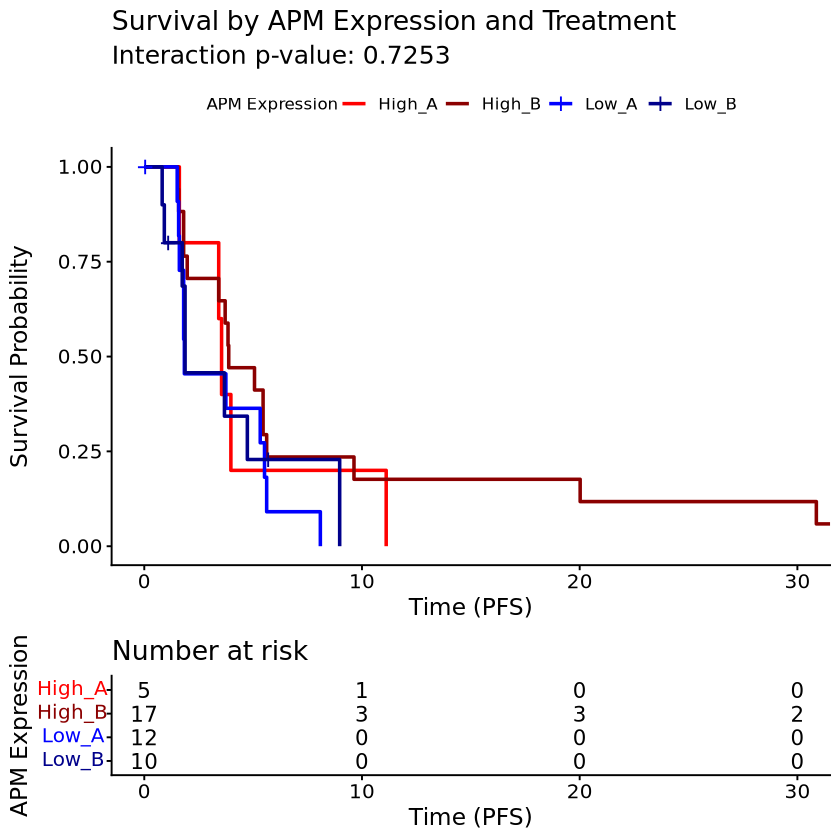

Ignoring unknown labels:
• colour : "Cell.Adhesion Expression"


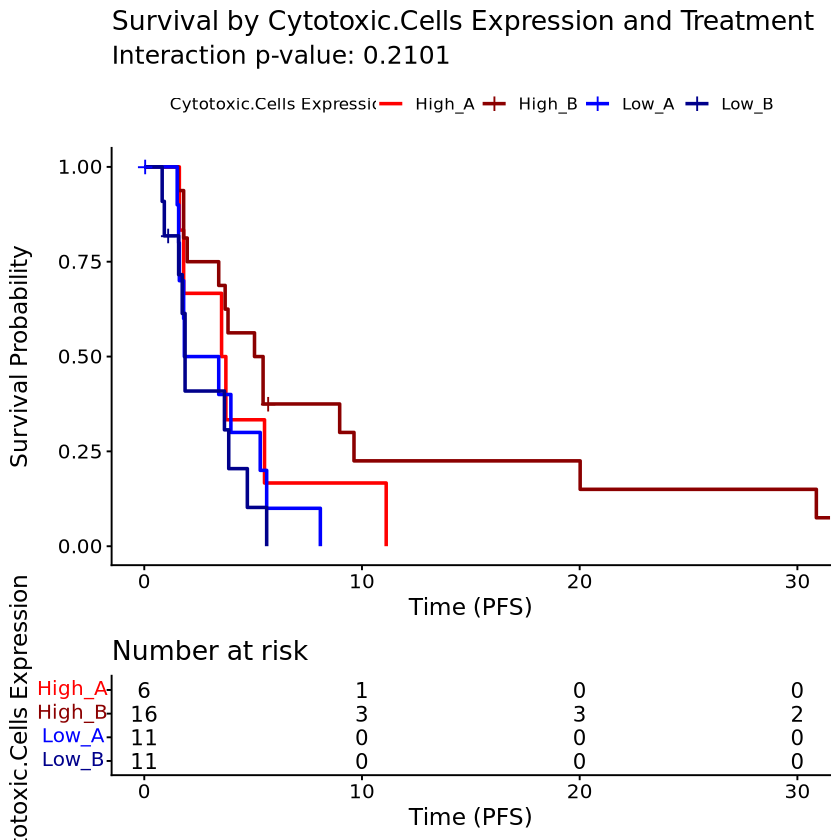

Ignoring unknown labels:
• colour : "Macrophages Expression"


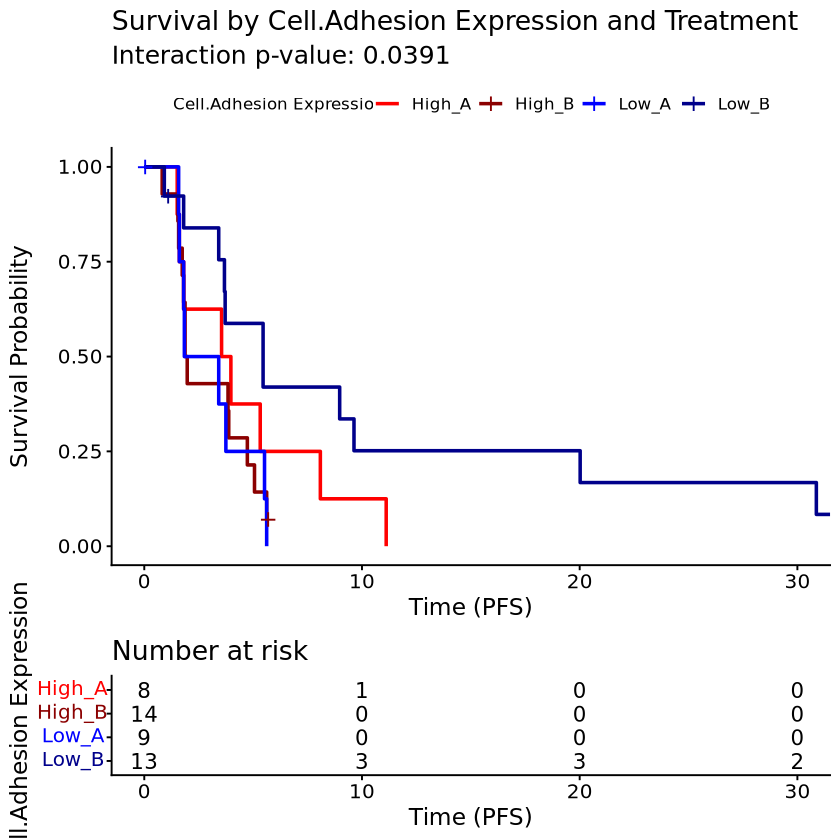

Ignoring unknown labels:
• colour : "HRD Expression"


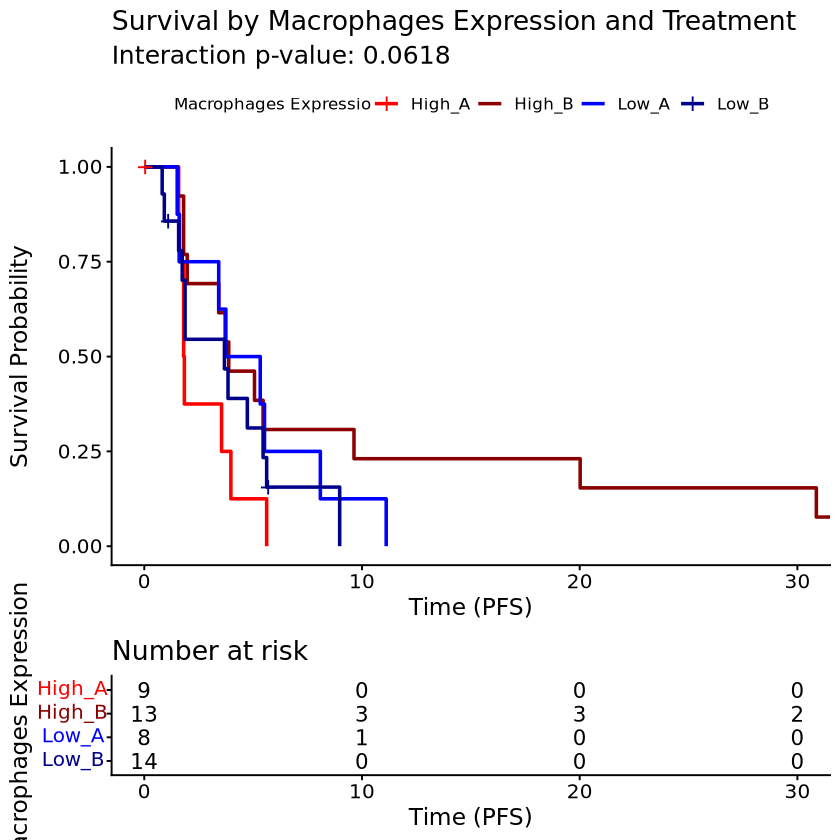

Ignoring unknown labels:
• colour : "PD.L2 Expression"


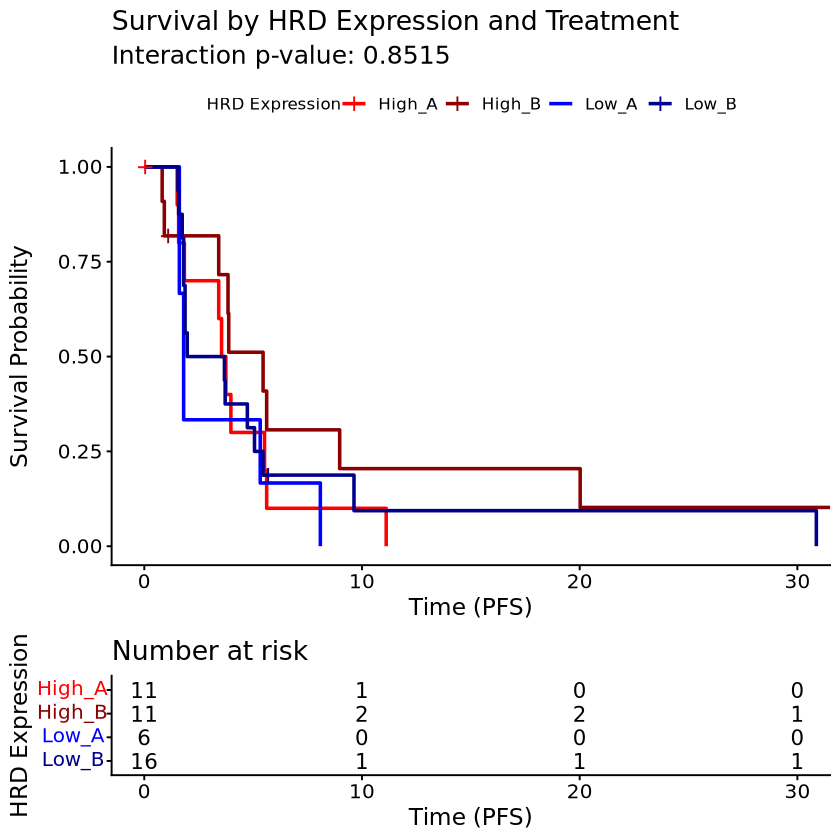

Ignoring unknown labels:
• colour : "Claudin.Low Expression"


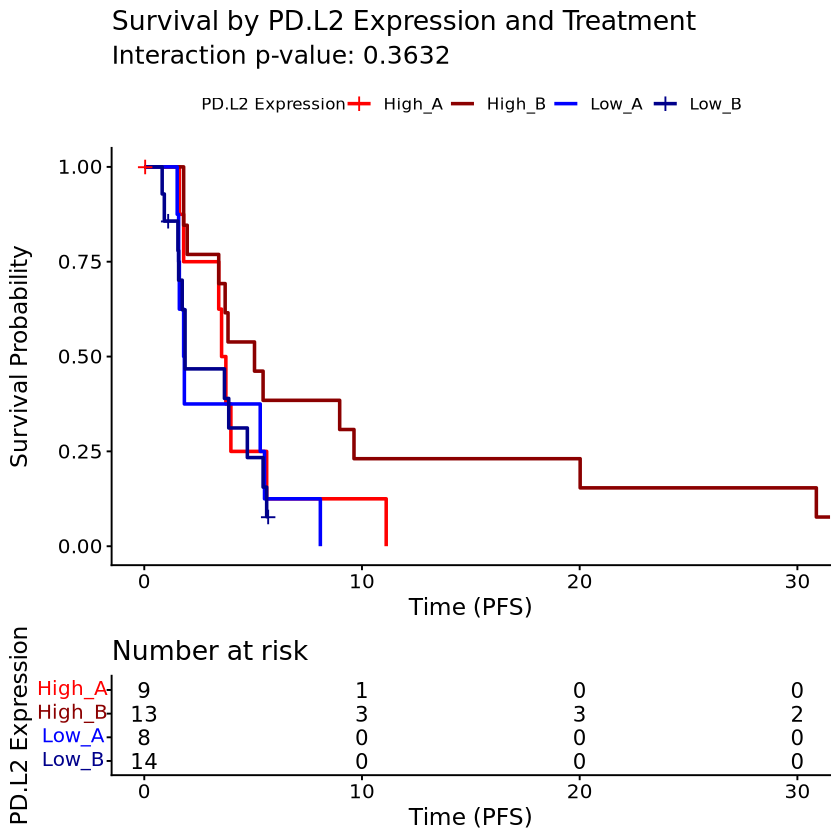

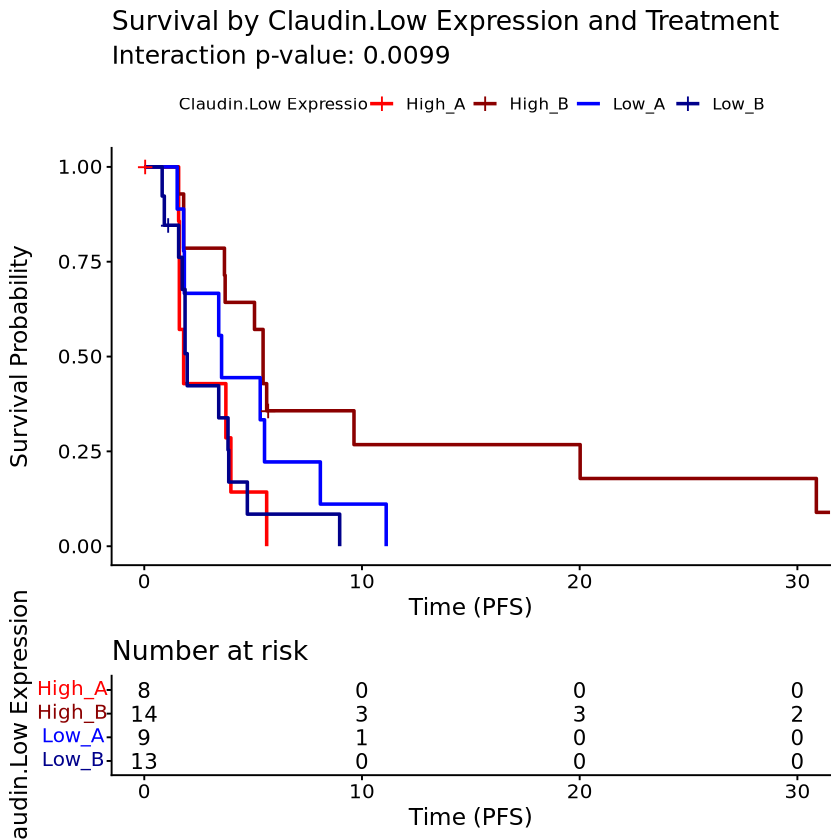

In [13]:
# PREDICTIVE BIOMARKER ANALYSIS

# Divide patients into two groups based on median gene expression scores
# and study whether any scores are potential predictive biomarkers

biomarker_results <- vector("list", length(cols_exp))
biomarker_plots <- vector("list", length(cols_exp))
cox_pvalues <- vector("list", length(cols_exp))
for (i in seq_along(cols_exp)) {
    gene <- cols_exp[i]

    # Calculate median for this gene
    gene_median <- median(df[[gene]])

    # Create binary groups: High (above median) and Low (at or below median)
    df[[paste0(gene, "_group")]] <- ifelse(df[[gene]] > gene_median, "High", "Low")

    # Ensure roughly equal group sizes by checking distribution
    group_counts <- table(df[[paste0(gene, "_group")]], useNA = "ifany")

    cat("\n", gene, "median:", round(gene_median, 3), "\n")
    cat("Group sizes:", group_counts, "\n")

    # Test for predictive biomarker effect using treatment interaction
    # A predictive biomarker shows differential treatment effect between high/low groups

    # Create interaction term for Cox regression: gene_group * treatment
    cox_formula_interaction <- as.formula(paste("Surv(time.pfs, event.pfs) ~",
                                              paste0(gene, "_group"), "+ treatment +",
                                              paste0(gene, "_group"), ": treatment"))

    # Fit Cox model with interaction
    cox_interaction <- coxph(cox_formula_interaction, data = df)

    # Check whether Cox regression analyses have met the assumption of proportional hazards
    ph_test_interaction <- cox.zph(cox_interaction)
    ph_test_interaction_coef <- ph_test_interaction$table
    ph_test_interaction_pvalue <- ph_test_interaction_coef[grep(":", rownames(ph_test_interaction_coef)), "p"]

    if (ph_test_interaction_pvalue < 0.05) {
        cat("Warning: Proportional hazards assumption may be violated for interaction term in gene", gene, "\n")
    }
    
    # Extract interaction p-value (key test for predictive biomarker)
    interaction_coef <- summary(cox_interaction)$coefficients
    interaction_pvalue <- interaction_coef[grep(":", rownames(interaction_coef)), "Pr(>|z|)"]

    # Calculate treatment effect (HR) in High/Low group
    # High expression group: Treatment B vs A
    df_high_group <- df[df[[paste0(gene, "_group")]] == "High", ]
    if(length(unique(df_high_group$treatment)) == 2) {  # both A and B are there
        cox_high <- coxph(Surv(time.pfs, event.pfs) ~ treatment, data = df_high_group)
        ph_test_high <- cox.zph(cox_high)
        ph_test_high_coef <- ph_test_high$table
        ph_test_high_pvalue <- ph_test_high_coef[1, "p"]
        if (ph_test_high_pvalue < 0.05) {
            cat("Warning: Proportional hazards assumption may be violated for high group in gene", gene, "\n")
        }
        hr_high <- exp(coef(cox_high))
        hr_high_ci <- exp(confint(cox_high))
        high_pvalue <- summary(cox_high)$coefficients[1, "Pr(>|z|)"]
    } else {
        high_pvalue <- NA
    }

    # Low expression group: Treatment B vs A
    df_low_group <- df[df[[paste0(gene, "_group")]] == "Low" & !is.na(df[[paste0(gene, "_group")]]), ]
    if(length(unique(df_low_group$treatment)) == 2) {
        cox_low <- coxph(Surv(time.pfs, event.pfs) ~ treatment, data = df_low_group)
        ph_test_low <- cox.zph(cox_low)
        ph_test_low_coef <- ph_test_low$table
        ph_test_low_pvalue <- ph_test_low_coef[1, "p"]
        if (ph_test_low_pvalue < 0.05) {
            cat("Warning: Proportional hazards assumption may be violated for low group in gene", gene, "\n")
        }
        hr_low <- exp(coef(cox_low))
        hr_low_ci <- exp(confint(cox_low))
        low_pvalue <- summary(cox_low)$coefficients[1, "Pr(>|z|)"]
    } else {
        low_pvalue <- NA
    }

    # Store results
    cox_pvalues[[i]] <- data.frame(
        gene = gene,
        interaction_pvalue = interaction_pvalue,
        high_group_pvalue = high_pvalue,
        low_group_pvalue = low_pvalue,
        stringsAsFactors = FALSE
    )

    biomarker_results[[i]] <- data.frame(
        gene = gene,
        hr_high = hr_high,
        hr_high_lower = hr_high_ci[1],
        hr_high_upper = hr_high_ci[2],
        high_pvalue = high_pvalue,
        hr_low = hr_low,
        hr_low_lower = hr_low_ci[1],
        hr_low_upper = hr_low_ci[2],
        low_pvalue = low_pvalue,
        stringsAsFactors = FALSE
    )

    # Create survival plots for each gene
    df_surv_plot <- df
    df_surv_plot$group_treatment <- paste(df_surv_plot[[paste0(gene, "_group")]],
                                           df_surv_plot$treatment, sep = "_")

    surv_object <- Surv(time = df_surv_plot$time.pfs,
                         event = df_surv_plot$event.pfs)
    fit <- survfit(surv_object ~ df_surv_plot$group_treatment)

    biomarker_plots[[i]] <- ggsurvplot(
        fit,
        data = df_surv_plot,
        pval = FALSE,
        risk.table = TRUE,
        legend.title = paste(gene, "Expression"),
        legend.labs = c("High_A", "High_B", "Low_A", "Low_B"),
        title = paste("Survival by", gene, "Expression and Treatment"),
        subtitle = paste("Interaction p-value:", round(interaction_pvalue, 4)),
        xlab = "Time (PFS)",
        ylab = "Survival Probability",
        palette = c("red", "darkred", "blue", "darkblue")
    )
}

biomarker_results <- bind_rows(biomarker_results)
biomarker_results

cox_pvalues <- bind_rows(cox_pvalues)
cox_pvalues

# plot the surv plot for each gene
for (i in seq_along(cols_exp)) {
    print(biomarker_plots[[i]])
}

In [14]:
# Create forest plot showing treatment effects by biomarker groups

# Prepare data for forest plot - showing HR for treatment effect in high vs low groups
df_forest <- data.frame()
for (i in 1:nrow(biomarker_results)) {
    gene <- biomarker_results$gene[i]

    # High group
    df_forest <- rbind(df_forest, data.frame(
        subgroup = paste(gene, "High"),
        hr = biomarker_results$hr_high[i],
        lower = biomarker_results$hr_high_lower[i],
        upper = biomarker_results$hr_high_upper[i],
        pvalue = biomarker_results$high_pvalue[i]
    ))

    # Low group
    df_forest <- rbind(df_forest, data.frame(
        subgroup = paste(gene, "Low"),
        hr = biomarker_results$hr_low[i],
        lower = biomarker_results$hr_low_lower[i],
        upper = biomarker_results$hr_low_upper[i],
        pvalue = biomarker_results$low_pvalue[i]
    ))
}

df_forest

subgroup,hr,lower,upper,pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TIS High,0.6723760,0.2376642,1.9022197,0.45440565
TIS Low,1.0434967,0.4223039,2.5784402,0.92649947
APM High,0.6919174,0.2474098,1.9350475,0.48275114
APM Low,0.7849128,0.3027815,2.0347610,0.61826654
Cytotoxic.Cells High,0.5930615,0.2216705,1.5866883,0.29809130
Cytotoxic.Cells Low,1.4419755,0.5774651,3.6007252,0.43309189
Cell.Adhesion High,1.5650404,0.5899939,4.1514858,0.36817947
Cell.Adhesion Low,0.3688455,0.1319942,1.0307039,0.05713405
Macrophages High,0.4107398,0.1558328,1.0826168,0.07195040


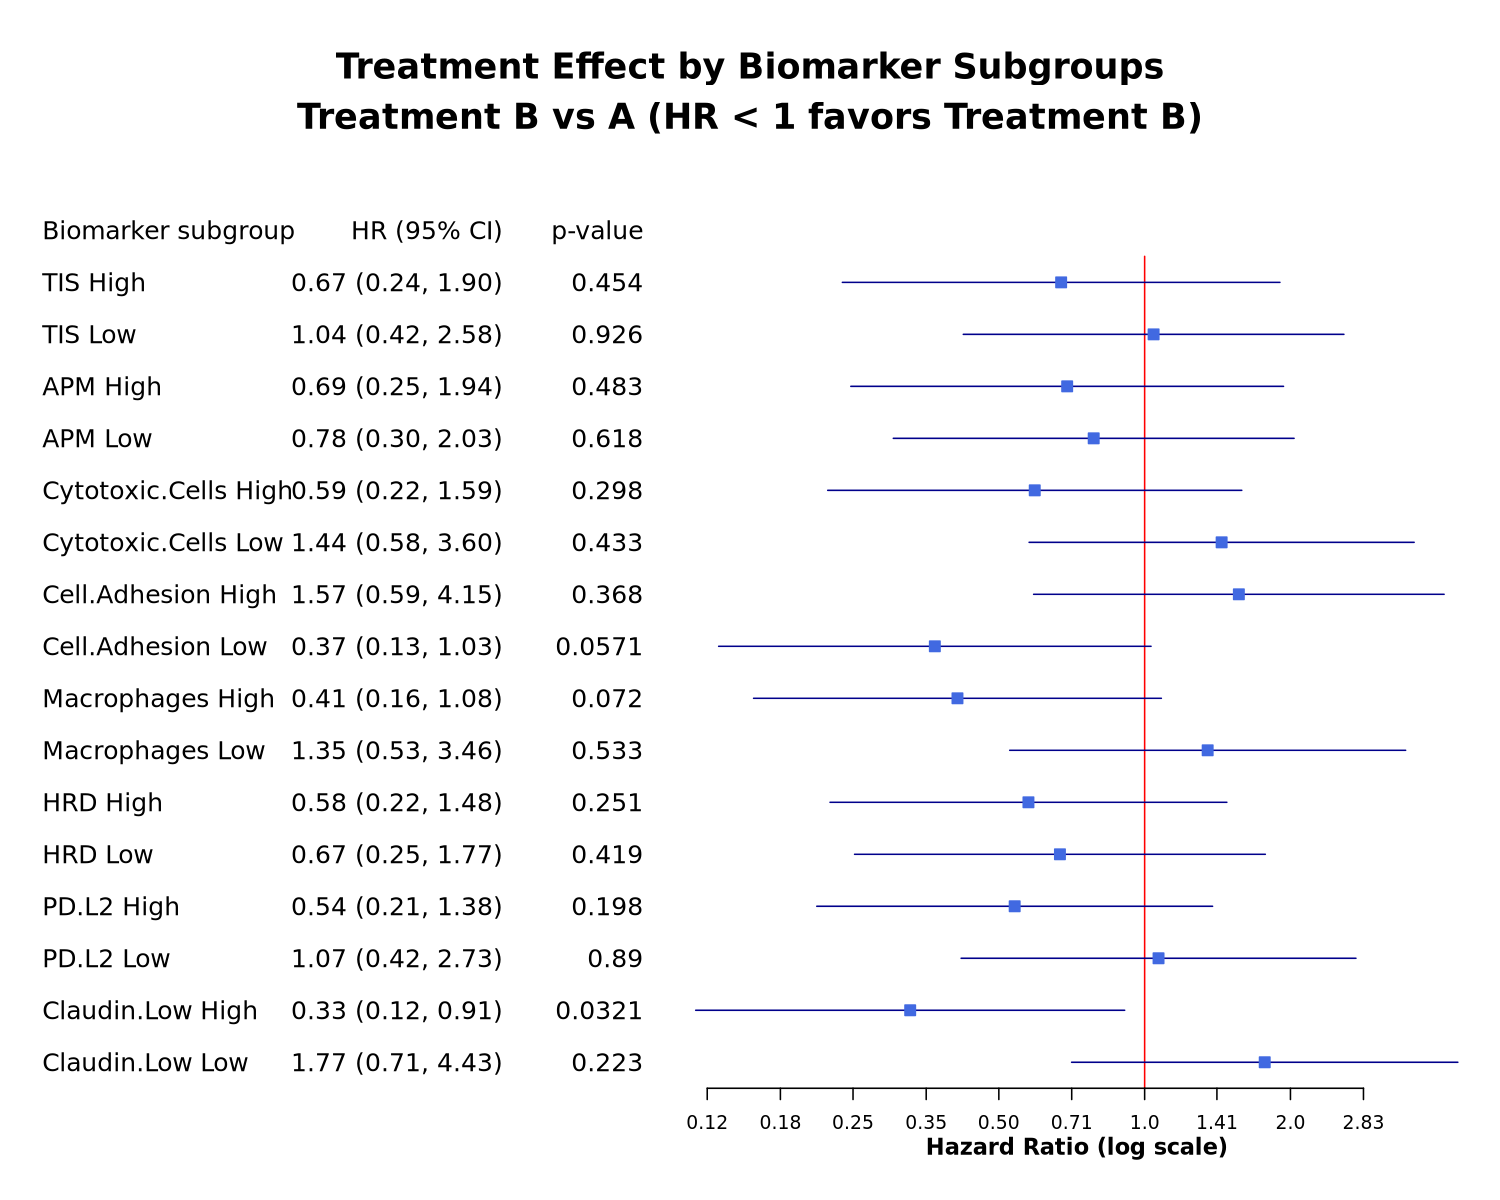

In [15]:
# Create a forest plot visualization
table_text <- cbind(
    c("Biomarker subgroup", df_forest$subgroup),
    c("HR (95% CI)", sprintf("%.2f (%.2f, %.2f)", df_forest$hr, df_forest$lower, df_forest$upper)),
    c("p-value", signif(df_forest$pvalue, 3))
)

options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150)

forestplot(
    labeltext = table_text,
    mean = c(NA, df_forest$hr),
    lower = c(NA, df_forest$lower),
    upper = c(NA, df_forest$upper),
    zero = 1,
    xlog = TRUE,
    clip = c(0.05, 20),
    boxsize = 0.2,
    line.margin = 0.2,
    xlab = "Hazard Ratio (log scale)",
    title = "Treatment Effect by Biomarker Subgroups\nTreatment B vs A (HR < 1 favors Treatment B)",
    txt_gp = fpTxtGp(
        label = grid::gpar(fontsize = 12),
        ticks = grid::gpar(fontsize = 18),
        xlab = grid::gpar(fontsize = 18, fontface = "bold"),
        title = grid::gpar(fontsize = 14, fontface = "bold")
    ),
    col = fpColors(box = "royalblue", line = "darkblue", zero = "red")
)

## Answer to Question 3a based on the analysis above
For each gene, the patients were divided into two groups by the median of the gene expression scores. A Cox model with the interaction term of the gene subgroup and treatment was fit (assumption of proportional hazards was met, and small-sample bias made no big difference and therefore ignored) to study whether the gene is a predictive biomarker -- treatment effect differs between High and Low subgroups. A KM plot was also drawn with the interaction P-value indicated. And furthermore, a Cox model was also fit to study how the treatment affects PFS within each subgroup.

In the end, a forest plot collects the key information and visualizes them.

As we go through the analysis for all the genes, we can find that there are two gene expression scores potential predictive biomarkers for the treatment:
Claudin.Low: interaction P-value = 0.01, and in its High subgroup, treatment B (atezolizumab) has a lower risk of progression at HR = 0.33 (95% CI 0.12-0.91, P-value=0.03);
Cell.Adhesion: interaction P-value = 0.04, and in its Low subgroup, treatment B (atezolizumab) has a lower risk of progression at HR = 0.37 (95% CI 0.13-1.03, P-value=0.06).

And one more gene expression score with moderate potential:
Macrophages: interaction P-value = 0.06, and in its High subgroup, treatment B (atezolizumab) has a lower risk of progression at HR = 0.41 (95% CI 0.16-1.08, P-value=0.07).

## Question 3 b): While the median is a commonly used cutoff when dichotomizing a population by a numeric value, it is not always the best cutoff. Suggest strategies for optimizing the cutoff value of a predictive or prognostic biomarker. (A brief discussion of methods is sufficient, no need to perform the calculations).

## Answer to Question 3b
Though dichotomization simplifies the statistical analysis and can lead to a clear interpretation of the results as shown above, but it can also be problematic:
1. Information lost, so the statistical power is reduced, especially in our case, where the patient number is not high.
2. May increase the risk of false positive.
3. Individuals close to the cutoff but on opposite sides are characterized as very different rather than very similar.
4. Hide potential non-linearity in the relation between the variable and treatment.

Some strategies may be considered:
1. Retain the original continuous scores to do the analysis. Then no information is lost, but the fitting requirement may be too high, and a simple standard Cox model may not be enough.
2. Multiple categories based on prior knowledge, e.g. Gleason score in prostate cancer grading system. But a general definition for the gene expression scores' levels may be missing.
3. Sustainable Technology Promotion Platform (STEPP), sliding window to formulate subgroups with overlaps. STEPP requires no pre-defined split, so it can realize the "multiple categories" purpose above.
4. Machine learning or deep learning methods that may be able to discover non-linearity in the relation between gene expression scores and the treatment. They can address the potential issue mentioned in strategy 1.